In [1]:
import polars

max_length = 10_000
dataframe = polars.read_csv('../data/chessData.csv')
dataframe = dataframe.sample(shuffle=True, seed=42, n=max_length)
print(dataframe.head())

shape: (5, 2)
┌─────────────────────────────────┬────────────┐
│ FEN                             ┆ Evaluation │
│ ---                             ┆ ---        │
│ str                             ┆ str        │
╞═════════════════════════════════╪════════════╡
│ r1bq2k1/1p3pbp/p2p1np1/2pPr3/P… ┆ +57        │
│ R5k1/2nbqpp1/3b1n1p/2pPp3/2P1P… ┆ +82        │
│ rqr3k1/3npp2/3p2p1/1N1P3p/P1pR… ┆ +116       │
│ 8/5pp1/k5p1/1pK5/8/7P/5PP1/8 w… ┆ -317       │
│ 3r2k1/5p1p/1RN1p3/5nP1/1p6/2b1… ┆ +46        │
└─────────────────────────────────┴────────────┘


In [2]:
import numpy
from typing import Generator, Tuple
import itertools
import chess

ProductPiece = Tuple[chess.PieceType, chess.Color]

def generator_pieces() -> Generator[ProductPiece, None, None]:
    return itertools.product(chess.PIECE_TYPES, chess.COLORS)

def tokenize_fen(fen: str):
    board = chess.Board(fen=fen)
    board_array = numpy.array([], ndmin=2)

    for piece_type, color in generator_pieces():
        # Obtiens les pièces du plateau
        square_set = board.pieces(piece_type, color)

        # Crée un masque (numpy va inverser les axes, donc on utilise mirror)
        mask = square_set.mirror().tolist()

        # Convertit le masque en tableau numpy et en one-hot
        piece_array = numpy.array(mask).astype(int)

        # Ajoute le tableau de pièces au tableau de plateau
        board_array = numpy.append(board_array, piece_array)
    
    board_array = board_array.astype(numpy.uint8)
    return tuple(board_array)

In [3]:
start_pos = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
result = tokenize_fen(start_pos)
print(len(result))
print(sum(result))

print(sum(result[:64]))  # white pawn
print(sum(result[64:128]))  # black pawn

print(sum(result[-128:-64]))  # white king
print(sum(result[-64:]))  # black king

768
32
8
8
1
1


In [4]:
fen_column = "FEN"
score_column = "Evaluation"

expression = polars.col(fen_column).map_elements(tokenize_fen, return_dtype=polars.List(polars.UInt8))
preprocess_df = dataframe.with_columns(expression)

# Filtrer les lignes où la colonne ne contient pas '#-'
filtered_df = preprocess_df.filter(~polars.col(score_column).str.contains('#-'))
filtered_df = filtered_df.filter(~polars.col(score_column).str.contains('#+'))

# Convertir la colonne en entier
filtered_df = filtered_df.with_columns(polars.col(score_column).cast(polars.Int16))

min_value = filtered_df[score_column].min()
max_value = filtered_df[score_column].max()

print(f"Min value : '{min_value:.2f}  -  Max value : {max_value:.2f}")

# Le dataset contient '#+0' ou '#-0' dans score quand il y'a un mat, on remplace par le maximum de la couleur
expression = (
    polars
    .when(polars.col(score_column).str.contains('#+'))
    .then(polars.lit(f'{max_value}'))

    .when(polars.col(score_column).str.contains('#-'))
    .then(polars.lit(f'{min_value}'))

    .otherwise(polars.col(score_column))
    .alias(score_column))

preprocess_df = preprocess_df.with_columns(expression)

# Convertit le dtype string de 'score' en dtype float
expression = polars.col(score_column).cast(polars.Int16)
preprocess_df = preprocess_df.with_columns(expression)

# Ré-équilibre le dataset 
expression = polars.col(score_column).ne(0)
preprocess_df = preprocess_df.filter(expression)


# Si une valeur dépasse 2000 ou -2000, le remplace par 2000 ou -2000
# expression = polars.col(score_column).clip(-2000, 2000)
# preprocess_df = preprocess_df.with_columns(expression)

# Renomme les colonnes en 'fen' et 'score'
preprocess_df = preprocess_df.rename({fen_column: 'fen', score_column: 'score'})

Min value : '-7918.00  -  Max value : 7224.00


In [5]:
print(preprocess_df.head())

shape: (5, 2)
┌─────────────┬───────┐
│ fen         ┆ score │
│ ---         ┆ ---   │
│ list[u8]    ┆ i16   │
╞═════════════╪═══════╡
│ [0, 0, … 0] ┆ 57    │
│ [0, 0, … 0] ┆ 82    │
│ [0, 0, … 0] ┆ 116   │
│ [0, 0, … 0] ┆ -317  │
│ [0, 0, … 0] ┆ 46    │
└─────────────┴───────┘


In [6]:
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt


class ChessDataset(Dataset):
    def __init__(self, preprocess_df: polars.DataFrame):
        self.dataframe = preprocess_df

    def __getitem__(self, index: int):
        # Récupère la FEN et le score
        array = self.dataframe['fen'][index]
        score = self.dataframe['score'][index]

        # Convertit le tableau numpy en tenseur PyTorch
        tensor_array = torch.tensor(array, dtype=torch.float32)
        tensor_score = torch.tensor(score, dtype=torch.float32)

        return tensor_array, tensor_score

    def __len__(self):
        return len(self.dataframe)
    
    def hist_score(self, bins: int = 51):
        """
        Affiche un histogramme de la colonne 'score'.

        Notes:
            Incrémente bins de 1 si celui-ci est pair, cela permet d'afficher le nombre de
            zeros dans la colonne 'score'. En impair, nous n'avons que pour > 0 ou < 0.

        Args:
            bins (int): Nombre de "bacs" pour l'histogramme. Defaults to 51.

        Returns:
            None
        """
        # Si le nombre de bacs est pair, on l'incrémente de 1
        bins = bins + 1 if bins % 2 == 0 else bins

        # Créer un histogramme de la colonne 'score'
        plt.hist(self.dataframe['score'], bins=bins)

        # Ajouter des étiquettes et un titre
        plt.xlabel('Valeur')
        plt.ylabel('Fréquence')
        plt.title('Distribution de la colonne "score"')

        # Afficher le graphique
        plt.show()

In [7]:
from torch import nn


class ChessModel(nn.Module):
    def __init__(self, input_size: int = 768):
        super(ChessModel, self).__init__()

        self.linear_1 = nn.Linear(input_size, 2048)
        self.linear_2 = nn.Linear(2048, 1024)
        self.linear_3 = nn.Linear(1024, 512)
        self.linear_4 = nn.Linear(512, 256)
        self.linear_5 = nn.Linear(256, 1)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _x = self.relu(self.linear_1(x))
        _x = self.relu(self.linear_2(_x))
        _x = self.relu(self.linear_3(_x))
        _x = self.relu(self.linear_4(_x))
        _x = self.linear_5(_x)
        return _x

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

In [8]:
from torchmetrics import MeanAbsoluteError
from typing import Literal
from src.train import train_model
from src.dataset import split_dataset

# Autres paramètres
device: Literal['cpu', 'cuda'] = 'cuda'

# Paramètres du dataset
batch_size: int = 256
random_seed: int = 42
ratio_tests: float = 0.2
ratio_validation: float = 0.2

# Paramètres du modèle (apprentissage)
num_epochs: int = 100
lr: float = 1e-3

# Paramètres du scheduler_lr (apprentissage)
start_factor: float = 1.0
end_factor: float = 0.01
total_iters: int = 20

metric = MeanAbsoluteError

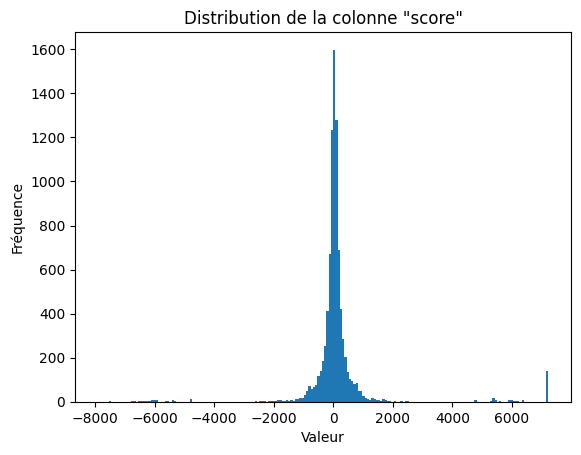

shape: (1_897, 2)
┌───────┬───────┐
│ score ┆ count │
│ ---   ┆ ---   │
│ i16   ┆ u32   │
╞═══════╪═══════╡
│ 1718  ┆ 1     │
│ -2040 ┆ 1     │
│ -966  ┆ 1     │
│ -385  ┆ 1     │
│ 697   ┆ 1     │
│ …     ┆ …     │
│ 61    ┆ 36    │
│ 23    ┆ 38    │
│ 13    ┆ 126   │
│ -13   ┆ 134   │
│ 7224  ┆ 137   │
└───────┴───────┘


In [9]:
model = ChessModel()
dataset = ChessDataset(preprocess_df=preprocess_df)
dataset.hist_score(bins=201)
print(preprocess_df.get_column('score').value_counts().sort("count"))

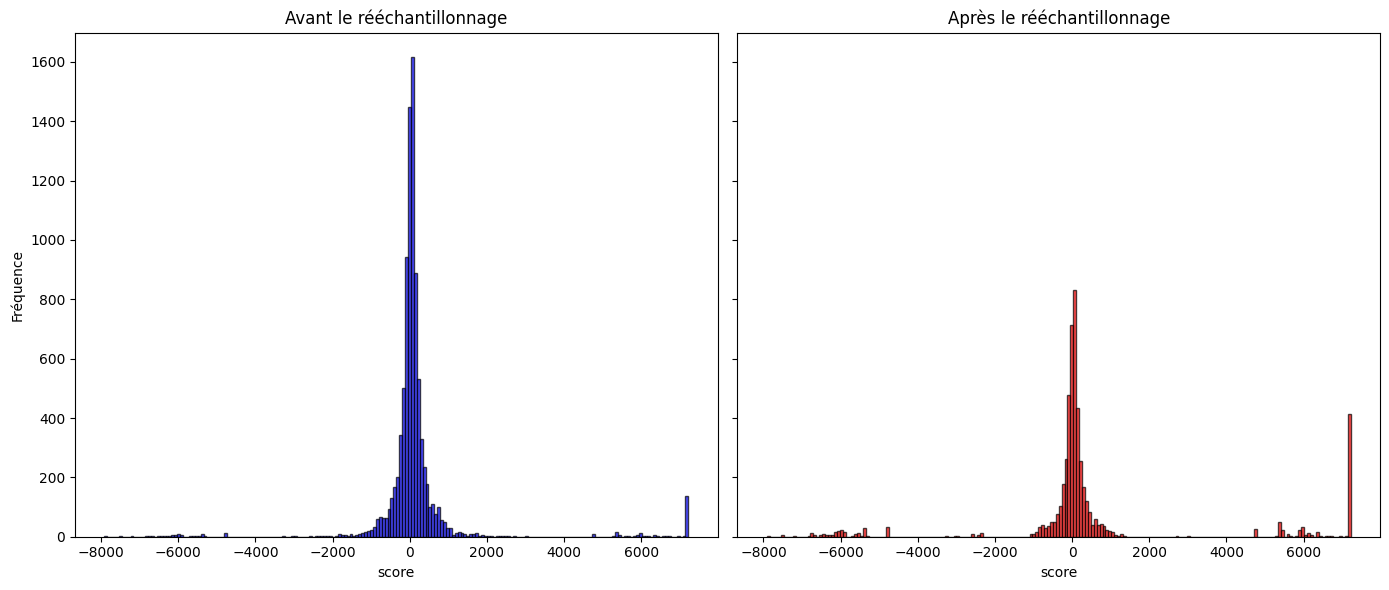

In [10]:
import polars 
import numpy as np
import matplotlib.pyplot as plt


def rebalance_dataframe(df: polars.DataFrame, column: str):
    # Calcul de la moyenne et de l'écart type de la colonne
    mean = df[column].mean()
    std = df[column].std()

    # Sous-échantillonnage des valeurs autour de la moyenne
    lower_bound = mean - std
    upper_bound = mean + std
    
    # Filtrons les valeurs autour de la moyenne
    subset_mean = df.filter((df[column] >= lower_bound) & (df[column] <= upper_bound))

    # Prenons un sous-échantillon aléatoire de ce subset
    subset_mean_sampled = subset_mean.sample(fraction=0.5)
    
    # Sur-échantillonnage des valeurs extrêmes
    extreme_threshold = 2 * std

    # Filtrons les valeurs extrêmes
    extremes = df.filter((df[column] < mean - extreme_threshold) | (df[column] > mean + extreme_threshold))

    # Dupliquons les valeurs extrêmes (par exemple, les tripler)
    extremes_oversampled = polars.concat([extremes]*3)
    
    # Combinons les deux DataFrames pour obtenir le résultat final
    result = polars.concat([subset_mean_sampled, extremes_oversampled])
    
    return result

# Fonction pour tracer les histogrammes
def plot_histogram(df_before, df_after, column, bins=30):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Avant le rééchantillonnage
    axs[0].hist(df_before[column].to_numpy(), bins=bins, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title("Avant le rééchantillonnage")
    axs[0].set_xlabel(column)
    axs[0].set_ylabel("Fréquence")
    
    # Après le rééchantillonnage
    axs[1].hist(df_after[column].to_numpy(), bins=bins, color='red', alpha=0.7, edgecolor='black')
    axs[1].set_title("Après le rééchantillonnage")
    axs[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

clean_df = rebalance_dataframe(preprocess_df, 'score')

# Affichage des histogrammes avant et après le rééchantillonnage
plot_histogram(preprocess_df, clean_df, 'score', bins=200)


In [11]:
list_loaders = split_dataset(
    dataset=dataset,
    batch_size=batch_size,
    shuffle_dataset=False,
    random_seed=random_seed,
    ratio_tests=ratio_tests,
    ratio_validation=ratio_validation
)

train_loader, tests_loader, validation_loader = list_loaders

train_model(
    device=device,
    
    model=model,
    train_loader=train_loader,
    tests_loader=tests_loader,
    validation_loader=validation_loader,
    
    num_epochs=num_epochs,
    lr=lr,
    
    start_factor=start_factor,
    end_factor=end_factor,
    total_iters=total_iters,
    
    metric=metric
)

AttributeError: 'str' object has no attribute '_apply'

In [ ]:
from src import MODEL_PATH

path = MODEL_PATH / 'model_33.pth'
dict_model = torch.load(path, map_location='cpu')
model = ChessModel().cpu()
model.load_state_dict(dict_model)


def analys_model(fen: str):
    fen_array = tokenize_fen(fen)
    fen_tensor = torch.tensor(fen_array, dtype=torch.float32).view(1, -1)
    prediction = model(fen_tensor).item()

    print(f"Prédiction du modèle: {prediction:.2f}")
    print()


list_fen = [
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",  # Position de base
    "r1bqkb1r/pppp1ppp/2n2n2/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 4 4",  # Mat berger, Mat en 1 pour blanc
    "4k3/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1",  # Noir n'ont qu'un roi
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/4K3 w kq - 0 1",  # Blanc n'ont qu'un roi
    "r3rbk1/p4ppp/8/2Nqp3/1p1P2b1/1P3N2/P2P1PPP/2RQR1K1 w - - 1 21"  # Position égale éloignée GMI (reputé légèrement favorable noir)
    ]

for fen in list_fen:
    analys_model(fen)